# Классификация изображений

**В этом соревновании требуется классифицировать автомобиль по фотографии.**

**Основная идея решения: взять предобученую на ImageNet сеть EfficientNetB6 и дообучить под нашу задачу.**

In [1]:
#!/opt/conda/bin/python3.7 -m pip install --upgrade pip

In [2]:
#Загружаем предобученные сети
!pip install -q efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# Загружаем обвязку под keras для использования продвинутых библиотек аугментации
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-boka5105
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29530 sha256=25cab3d2ab652d8af9d71dc70f0bc32b2800cc05035e5586e1fea052dadae750
  Stored in directory: /tmp/pip-ephem-wheel-cache-zxguiwkv/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os
import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.applications.xception import Xception

import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C

from ImageDataAugmentor.image_data_augmentor import *
import albumentations

import efficientnet.tfkeras as efn

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['train.zip', 'sample-submission.csv', 'test.zip', 'train.csv']
Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.17.5
Tensorflow   : 2.3.1
Keras        : 2.4.0


In [5]:
# Проверяем, что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
!pip freeze > requirements.txt

# Функции

In [7]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

def get_augment():
    augmentations = albumentations.Compose([
        albumentations.HorizontalFlip(p=0.5),
        albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
        albumentations.OneOf([
            albumentations.CenterCrop(height=224, width=200),
            albumentations.CenterCrop(height=200, width=224),
        ],p=0.5),
        albumentations.OneOf([
            albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
            albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
        ],p=0.5),
        albumentations.GaussianBlur(p=0.05),
        albumentations.HueSaturationValue(p=0.5),
        albumentations.RGBShift(p=0.5),
        albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
        albumentations.Resize(IMG_SIZE, IMG_SIZE)
    ])

    return augmentations

# Основные настройки

In [8]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 16 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4 # темп обучения
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "../working/car/" # рабочая директория

In [9]:
# Очищаем PATH
import shutil

if os.path.exists(PATH):
    shutil.rmtree(PATH)

In [10]:
# Устаналиваем конкретное значение random seed для воспроизводимости
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

#Создадим директорию,если её нет
if not os.path.exists(PATH):
    os.makedirs(PATH,exist_ok=False)

# EDA / Анализ данных

In [11]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [53]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


15661 записей, где Id - идентификатор картинки,а Category - класс авто

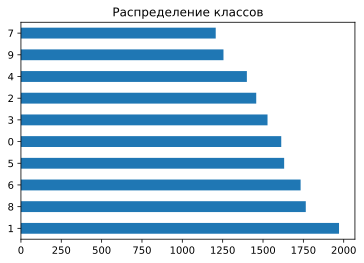

In [12]:
train_df.Category.value_counts().plot(kind='barh', title='Распределение классов')
# распределение классов достаточно равномерное - это хорошо

In [13]:
print('Распаковываем картинки')
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['test_upload', 'train']


Пример картинок (random sample)


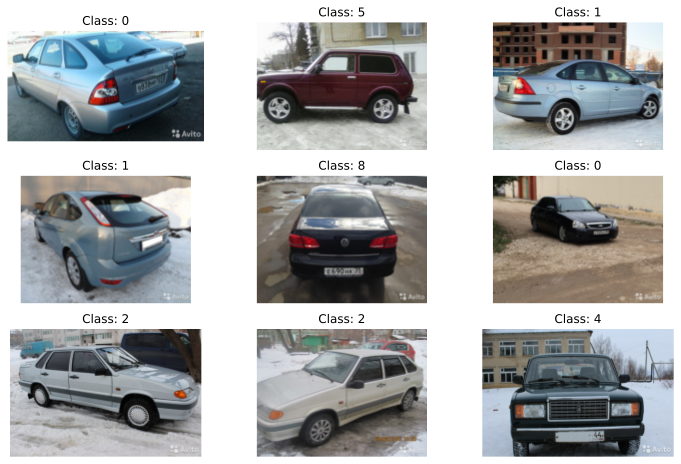

In [14]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Очевидно,что классы обозначают модели авто.

Посмотрим на примеры картинок и их размеры, чтоб понимать, как их лучше обработать и сжимать.

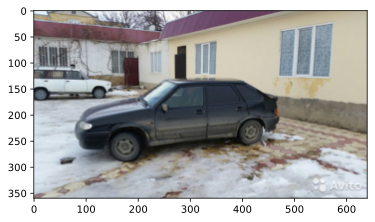

(640, 360)

In [15]:
image = PIL.Image.open(PATH+'/train/2/100998.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Срез картинок для ускоренного обучения

Работа на полных данных занимает достаточно продолжительное время.

Для ускоренного тестирования механизмов аугментации,подбора LR и т.д. добавлен отдельный блок,в котором около 1000 картинок копируется в отдельную тестовую папку,с которой в последующем работает модель.

После тестирования код закомментирован.

In [16]:
PATH_TEST = "../working/car_test/" #Тестовая директория

In [17]:
# #очищаем каталог,если он создан.Либо создаем новый
# if os.path.exists(PATH_TEST):
#     shutil.rmtree(PATH_TEST)
# else:
#     os.makedirs(PATH_TEST,exist_ok=False)
    

# #Упрощенный датафрейм
# train_df = pd.read_csv(DATA_PATH+"train.csv")
# train_copy = pd.DataFrame(data=None, columns=train_df.columns)

# for i in range(0,10):
#     train_copy = pd.concat([train_copy,train_df[train_df.Category == i].iloc[:100,:]])
    
# train_df = train_copy.copy()
# train_df = train_df.reset_index()


# #копируем изображения
# def copy_file(id_f,cat):
#     file_orig = PATH + f'train/{cat}/{id_f}'
#     path_copy = PATH_TEST + f'train/{cat}'
#     #проверка каталога с последующим созданием
#     if not os.path.exists(path_copy):
#         os.makedirs(path_copy)
    
#     shutil.copy(file_orig, path_copy)

# for i in range(0,len(train_df)):
#     copy_file(train_df.loc[i].Id,train_df.loc[i].Category)
    
    
# #проверить,что скопировались
# for dirname, _, filenames in os.walk('./car_test/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
        

# Подготовка данных

## Аугментация данных

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT,
    horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1. / 255)

Попробуем использовать albuminations, настройки которого отдельно вынесены в get_augment()

https://github.com/mjkvaak/ImageDataAugmentor

In [19]:
train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = get_augment(),
        validation_split=VAL_SPLIT,
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255)

## Генерация данных

In [20]:
#приводим путь к единому значению,когда нужны полные данные
PATH_TEST = PATH

In [21]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH_TEST +'train/',  
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training')

test_generator = train_datagen.flow_from_directory(
    PATH_TEST +'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    subset='validation')

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


Генератор показывает:  
Трейн: 13232 изображения,в которых 10 классов.   
Тест: 2329 изображения,в которых 10 классов.   
Валидация: 6675 изображения.  

# Построение модели

Воспользуемся предобученной сетью EfficientNetB6.

Она кажется оптимальной по соотношению скорости и точности обучения исходя из рейтингов моделей. Также в ней приемлемое количество параметров.

https://sotabench.com/benchmarks/image-classification-on-imagenet

https://paperswithcode.com/sota/image-classification-on-imagenet

In [22]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

165527552/165527152 [==============================] - 2s 0us/step


In [23]:
# Для начала заморозим веса EfficientNetB6 и обучим только "голову". 
# Делаем это для того, чтобы хорошо обученные признаки на Imagenet не затирались в самом начале нашего обучения.
base_model.trainable = False

In [24]:
base_model.summary()

Model: "efficientnet-b6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 56) 1512        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 56) 224         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 56) 0           stem_bn[0][0]                    
____________________________________________________________________________________

Total params: 40,960,136
Trainable params: 0
Non-trainable params: 40,960,136
__________________________________________________________________________________________________


In [25]:
# Устанавливаем новую "голову" (head)

model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),) # объединяем все признаки в единый вектор 

# Экспериментируем с архитектурой - добавляем ещё один полносвязный слой, dropout и batch-нормализацию

model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [26]:
model.summary()
# Рекомендация: Попробуйте добавить Batch Normalization

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 7, 7, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,810
Trainable params: 593,162
Non-trainable params: 40,960,648
______________________________________

In [27]:
# сколько слоев
print(len(model.layers))

6


In [29]:
# Проверяем,какие слои обучаются,а какие нет
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f9cce206f10> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fa16fe7dd50> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9ccd4fbc50> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f9cce129b90> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9ccd50b090> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9ccd506590> True


# Обучение модели

Разобьем обучение модели на 3 шага:  
-на 1 шаге не будем дообучать модель.Посмотрим,какую точность она покажет.   
-на 2 шаге дообучим половину слоев модели.  
-на 3 шаге дообучим все слои модели.  

При этом с каждым шагом будем уменьшать LR. 

In [32]:
#Добавим ModelCheckpoint, чтобы сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.
#Добавим EarlyStopping, чтобы не обучать модель,если val_accuracy не растёт больше 5 итераций

checkpoint = C.ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = C.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

## Шаг 1

In [66]:
print("Количество слоёв в базовой модели: ", len(base_model.layers))

Количество слоёв в базовой модели:  659


In [30]:
LR=0.001

model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [33]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/10
827/827 [==============================] - ETA: 0s - loss: 1.6386 - accuracy: 0.4388
Epoch 00001: saving model to best_model.hdf5
827/827 [==============================] - 170s 205ms/step - loss: 1.6386 - accuracy: 0.4388 - val_loss: 1.1287 - val_accuracy: 0.5955
Epoch 2/10
827/827 [==============================] - ETA: 0s - loss: 1.3580 - accuracy: 0.5200
Epoch 00002: saving model to best_model.hdf5
827/827 [==============================] - 175s 211ms/step - loss: 1.3580 - accuracy: 0.5200 - val_loss: 1.0667 - val_accuracy: 0.6114
Epoch 3/10
827/827 [==============================] - ETA: 0s - loss: 1.2817 - accuracy: 0.5413
Epoch 00003: saving model to best_model.hdf5
827/827 [==============================] - 169s 204ms/step - loss: 1.2817 - accuracy: 0.5413 - val_loss: 1.0165 - val_accuracy: 0.6222
Epoch 4/10
827/827 [==============================] - ETA: 0s - loss: 1.2298 - accuracy: 0.5650
Epoch 00004: saving model to best_model.hdf5
827/827 [======================

In [34]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

146/146 [==============================] - 24s 167ms/step - loss: 0.8258 - accuracy: 0.7072
Accuracy: 70.72%


Удивительно, насколько эта модель хорошо умеет извлекать признаки!
Даже без дообучения получаем столь высокий Accuracy

Посмотрим графики обучения:

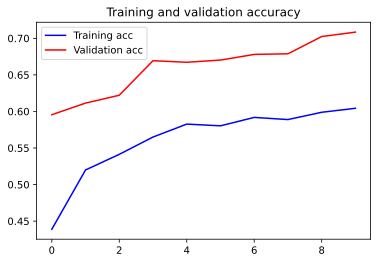

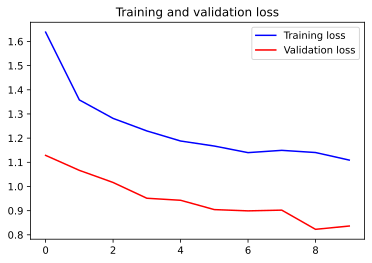

In [35]:
plot_history(history)

По графикам видно,что модель не дообучилась, что логично. Движемся дальше.

In [36]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_step1.hdf5')
model.load_weights('best_model.hdf5')

## Шаг 2

Дообучим половину слоёв модели

In [38]:
base_model.trainable = True

fine_tune_at = len(base_model.layers)//2

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [39]:
len(base_model.trainable_variables)

291

In [40]:
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f9cce206f10> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fa16fe7dd50> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9ccd4fbc50> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f9cce129b90> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f9ccd50b090> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f9ccd506590> True


In [41]:
LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 7, 7, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,810
Trainable params: 38,289,632
Non-trainable params: 3,264,178
____________________________________

In [45]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/10
827/827 [==============================] - ETA: 0s - loss: 1.0728 - accuracy: 0.6301
Epoch 00001: saving model to best_model.hdf5
827/827 [==============================] - 204s 246ms/step - loss: 1.0728 - accuracy: 0.6301 - val_loss: 0.4278 - val_accuracy: 0.8491
Epoch 2/10
827/827 [==============================] - ETA: 0s - loss: 0.5375 - accuracy: 0.8080
Epoch 00002: saving model to best_model.hdf5
827/827 [==============================] - 204s 246ms/step - loss: 0.5375 - accuracy: 0.8080 - val_loss: 0.2843 - val_accuracy: 0.8970
Epoch 3/10
827/827 [==============================] - ETA: 0s - loss: 0.3935 - accuracy: 0.8603
Epoch 00003: saving model to best_model.hdf5
827/827 [==============================] - 203s 246ms/step - loss: 0.3935 - accuracy: 0.8603 - val_loss: 0.2397 - val_accuracy: 0.9103
Epoch 4/10
827/827 [==============================] - ETA: 0s - loss: 0.3090 - accuracy: 0.8903 ETA: 2s - loss:
Epoch 00004: saving model to best_model.hdf5
827/827 [======

In [46]:
model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [47]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

146/146 [==============================] - 26s 178ms/step - loss: 0.1899 - accuracy: 0.9412
Accuracy: 94.12%


Точность выросла на 24%. 

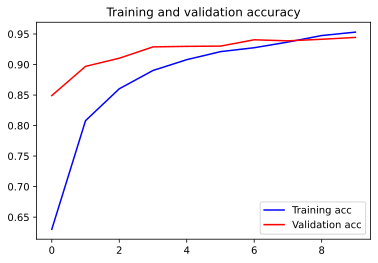

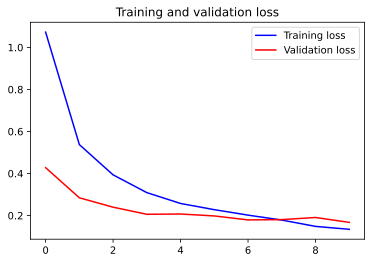

In [48]:
plot_history(history)

По графикам видно,что точность и ошибка практически вышли на плато. Посмотрим результаты на 3 шаге.

## Шаг 3

Дообучим все слои модели.

In [49]:
base_model.trainable = True

In [51]:
LR=0.00001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [54]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/10
827/827 [==============================] - ETA: 0s - loss: 0.0758 - accuracy: 0.9731
Epoch 00001: saving model to best_model.hdf5
827/827 [==============================] - 400s 484ms/step - loss: 0.0758 - accuracy: 0.9731 - val_loss: 0.1663 - val_accuracy: 0.9530
Epoch 2/10
827/827 [==============================] - ETA: 0s - loss: 0.0750 - accuracy: 0.9732
Epoch 00002: saving model to best_model.hdf5
827/827 [==============================] - 401s 485ms/step - loss: 0.0750 - accuracy: 0.9732 - val_loss: 0.1514 - val_accuracy: 0.9569
Epoch 3/10
827/827 [==============================] - ETA: 0s - loss: 0.0752 - accuracy: 0.9735
Epoch 00003: saving model to best_model.hdf5
827/827 [==============================] - 400s 484ms/step - loss: 0.0752 - accuracy: 0.9735 - val_loss: 0.1545 - val_accuracy: 0.9591
Epoch 4/10
827/827 [==============================] - ETA: 0s - loss: 0.0709 - accuracy: 0.9751
Epoch 00004: saving model to best_model.hdf5
827/827 [======================

In [55]:
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [56]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100)) #60.67%  #Аугментация = 68.67%

146/146 [==============================] - 25s 171ms/step - loss: 0.1671 - accuracy: 0.9541
Accuracy: 95.41%


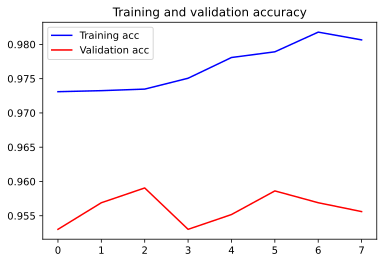

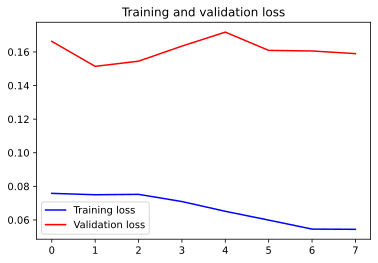

In [57]:
plot_history(history)

На графиках видно,что модель немного переобучилась.

# Test Time Augmentation

Попробуем увеличить точность предсказаний.

Аугментируем тестовые изображения и сделаем несколько предсказаний одной картинки в разном виде. 
Взяв среднее значение из нескольких предсказаний получим итоговое предсказание. Это должно увеличить точность предсказания.

In [58]:
model.load_weights('best_model.hdf5')

In [59]:
test_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = get_augment(),
        validation_split=VAL_SPLIT,
        )

In [60]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [61]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

418/418 [==============================] - 70s 168ms/step


In [62]:
predictions = np.argmax(pred, axis=-1) 
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items())
predictions = [label_map[k] for k in predictions]

In [63]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [64]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9
